Looking at the 2m cadence TESS data from sector 31

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [129]:
path = '/media/david/5tb_storage1/cc_cet/tess/MAST_2020-12-21T2128/TESS/tess2020294194027-s0031-0000000337219837-0198-s/'

In [130]:
lcpath = glob.glob('{}*lc.fits'.format(path))[0]
lcpath

'/media/david/5tb_storage1/cc_cet/tess/MAST_2020-12-21T2128/TESS/tess2020294194027-s0031-0000000337219837-0198-s/tess2020294194027-s0031-0000000337219837-0198-s_lc.fits'

In [131]:
data = fits.getdata(lcpath,1)
data.names

['TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2']

In [132]:
t, f, e, q, bk = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY'], data['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
#fit = np.polyval((np.polyfit(t,f,2)), t)
#f = (f/fit)-1
#e = (e/fit)
#cut_mask = (bk < 1.1*np.median(bk))
lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_nans()#.remove_outliers(sigma=5)

<AxesSubplot:xlabel='Time', ylabel='Flux'>

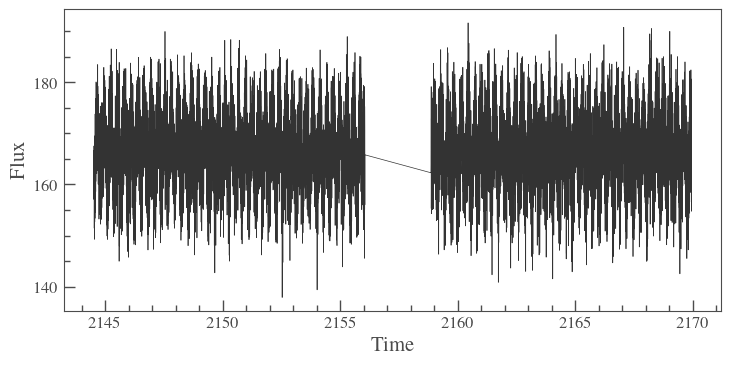

In [133]:
lc.plot()

In [134]:
pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=15*u.day)
#pg.plot()

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


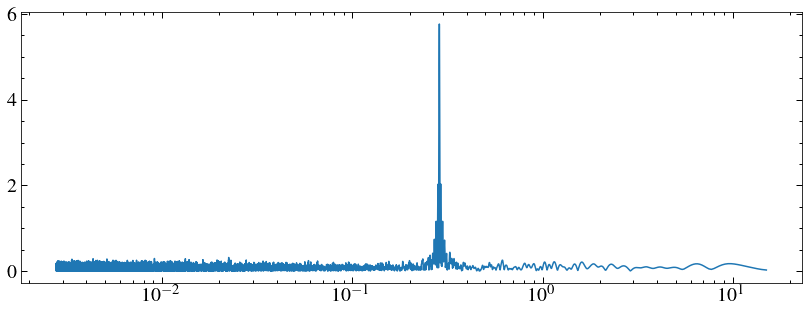

In [135]:
plt.plot(pg.period, pg.power)
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0.3, 1)

<AxesSubplot:xlabel='Phase', ylabel='Flux'>

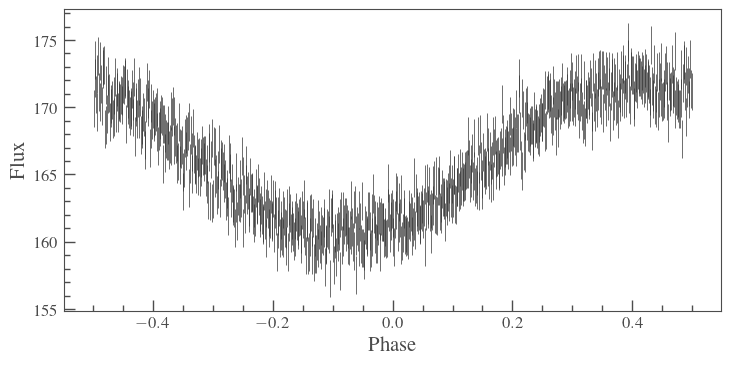

In [136]:
lc.fold(pg.period_at_max_power).bin(20).errorbar()

<AxesSubplot:xlabel='Time', ylabel='Flux [$\\mathrm{\\%}$]'>

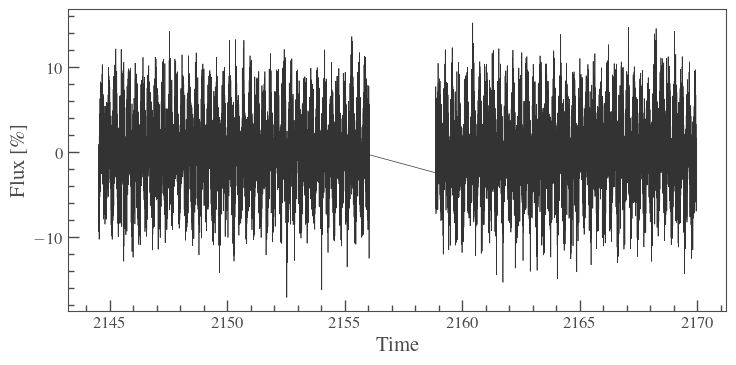

In [137]:
lc1 = lc.normalize(unit='percent')
lc1.flux -=100
lc1.plot()

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


3.4666049147608056 %


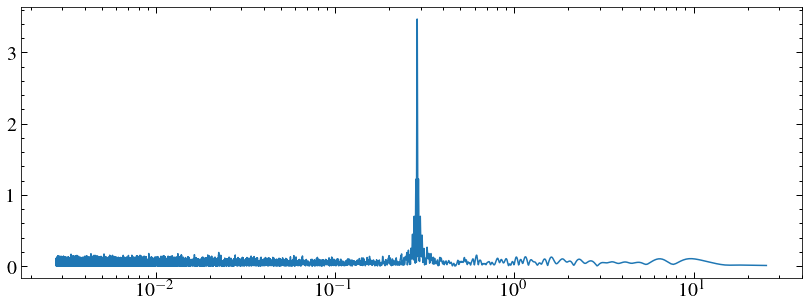

In [166]:
pg1 = lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=(lc.time[-1]-lc.time[0])*u.day)
plt.plot(pg1.period, pg1.power)
plt.xscale('log')
print(pg1.max_power)

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude          frequency            phase       
    ------------------ ------------------ ------------------
    -3.464159094295085 3.4874559464778145 1.2982676739155343
[3.88422195e-02 2.29364364e-04 4.94748586e-01]
Period = 6.881807359957909 0.0004526053927363888 h
Amplitude = -3.464159094295085 0.038842219463640075
Phase = 1.2982676739155343 0.4947485859182388


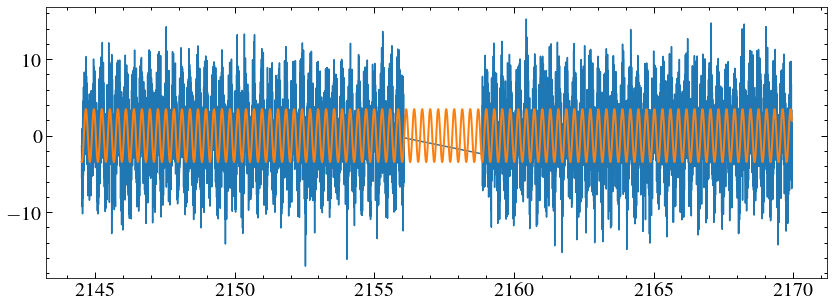

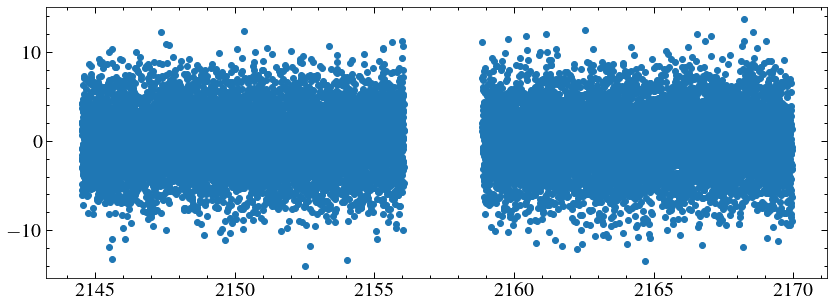

2144.8207783745556
Amplitude = 3.4641590955448995 0.03884099935534628
Phase = -0.20173230879196188 0.0017898689926790516
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      frequency        phase        
    ------------------ --------- --------------------
    3.4641590955448995       1.0 -0.20173230879196188
[0.038841   0.00178987]


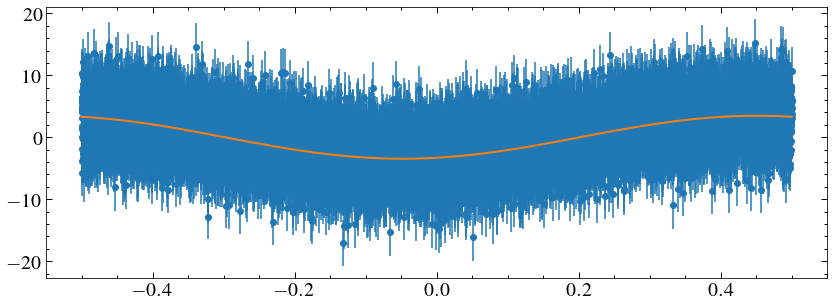

In [271]:
fitter = fitting.LevMarLSQFitter()


sin_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value, phase=0)#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
sin_fit = fitter(sin_mod, lc1.time, lc1.flux, weights = 1/lc1.flux_err, maxiter=100000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 
timefit = np.linspace(lc1.time[0], lc1.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
print('Phase =', sin_fit.phase.value, sin_fit_e[2])
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit(lc1.time))
plt.show()

t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.25)
print(t0)
lcf = lc1.fold(1/sin_fit.frequency.value)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')
fold_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= 1, phase=0, fixed={'frequency':True})#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
fold_fit = fitter(fold_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
fold_time = np.linspace(-0.5, 0.5, 100)
plt.plot(fold_time, fold_fit(fold_time), c='C1', lw=2, zorder=10)

print('Amplitude =', fold_fit.amplitude.value, fold_fit_e[0])
print('Phase =', fold_fit.phase.value, fold_fit_e[1])
print(fold_fit)
print(fold_fit_e)

Phase error seems like nonsense so estimate it from the %age errors on the other two?

In [260]:
print(fold_fit_e[0]/abs(fold_fit.amplitude.value))
print(fold_fit_e[1]/fold_fit.frequency.value)
print(1/sin_fit.frequency.value*fold_fit_e[1])

0.011212244670083991
0.0017898689926790516
0.0005132305669657977


<AxesSubplot:xlabel='Time', ylabel='Flux'>

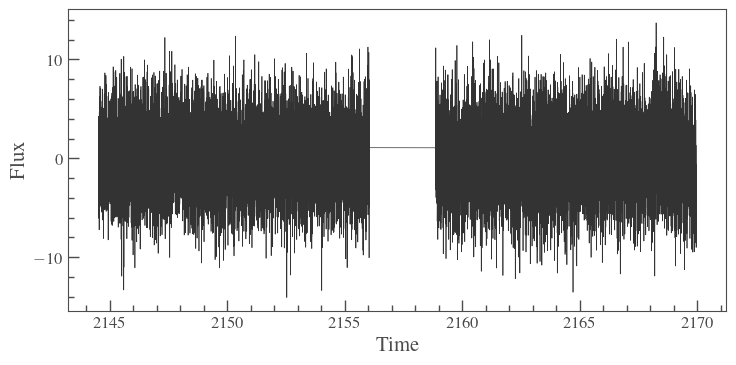

In [140]:
lc2 = lk.LightCurve(time=lc1.time, flux=lc1.flux-sin_fit(lc1.time), flux_err=lc1.flux_err )
#lc2.flux -= sin_fit(lc1.time)
lc2.plot()

32.27219294372088 min
0.1923583817283496


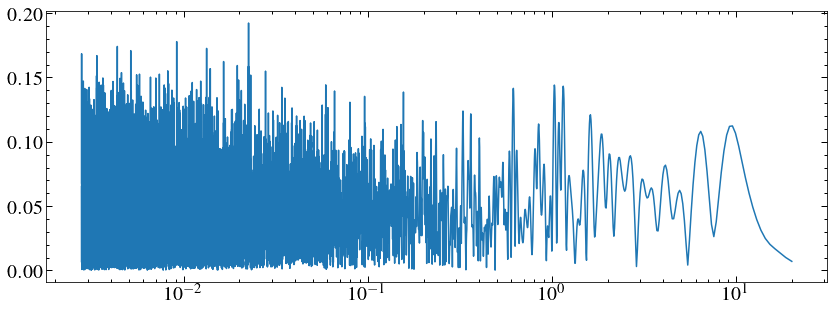

In [141]:
pg2 = lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
plt.plot(pg2.period, pg2.power)
plt.xscale('log')
print(pg2.period_at_max_power.to(u.min))
print(pg2.max_power)

<AxesSubplot:xlabel='Phase', ylabel='Flux'>

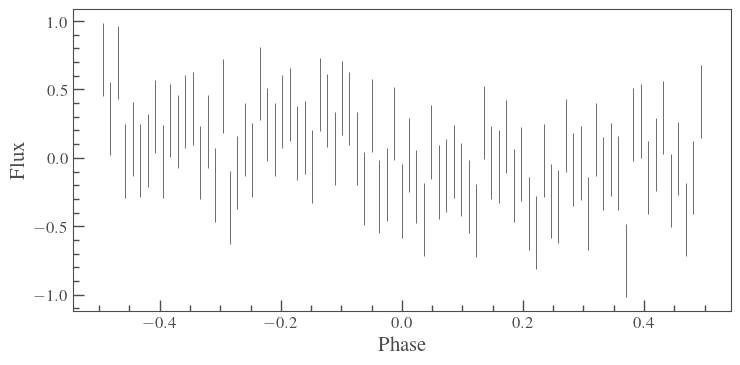

In [142]:
lc2.fold(pg2.period_at_max_power).bin(200).errorbar()

In [143]:
pg1.period_at_max_power/pg2.period_at_max_power

<Quantity 12.79635344>

In [190]:
"""sin_mod2 =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value) +models.Sine1D(amplitude=pg2.max_power.value, frequency= pg2.frequency_at_max_power.value)
sin_fit2 = fitter(sin_mod2, lc1.time, lc1.flux, weights = 1/lc1.flux_err)
sin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 

plt.plot(timefit, sin_fit2(timefit), c='C1', lw=2) 
print(sin_fit2)
print(sin_fit_e2)
print('Period1 =', (1/sin_fit2[0].frequency.value)*24, (sin_fit_e2[1]/(sin_fit2[1].frequency.value**2))*24, 'h')
print('Amplitude1 =', sin_fit2[0].amplitude.value, sin_fit_e2[0])
print('Period2 =', (1/sin_fit2[1].frequency.value)*24, (sin_fit_e2[4]/(sin_fit2[1].frequency.value**2))*24, 'h')
print('Amplitude2 =', sin_fit2[1].amplitude.value, sin_fit_e2[3])
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit2(lc1.time))
plt.show()

#t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.75)
#lcf = lc1.fold(1/sin_fit.frequency.value, t0=t0).bin(50)
#plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o') """

"sin_mod2 =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value) +models.Sine1D(amplitude=pg2.max_power.value, frequency= pg2.frequency_at_max_power.value)\nsin_fit2 = fitter(sin_mod2, lc1.time, lc1.flux, weights = 1/lc1.flux_err)\nsin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))\nplt.plot(lc1.time, lc1.flux) \n\nplt.plot(timefit, sin_fit2(timefit), c='C1', lw=2) \nprint(sin_fit2)\nprint(sin_fit_e2)\nprint('Period1 =', (1/sin_fit2[0].frequency.value)*24, (sin_fit_e2[1]/(sin_fit2[1].frequency.value**2))*24, 'h')\nprint('Amplitude1 =', sin_fit2[0].amplitude.value, sin_fit_e2[0])\nprint('Period2 =', (1/sin_fit2[1].frequency.value)*24, (sin_fit_e2[4]/(sin_fit2[1].frequency.value**2))*24, 'h')\nprint('Amplitude2 =', sin_fit2[1].amplitude.value, sin_fit_e2[3])\nplt.show()\nplt.scatter(lc1.time, lc1.flux-sin_fit2(lc1.time))\nplt.show()\n\n#t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.75)\n#lcf = lc1.fold(1/sin_fit.frequency.value, t

In [163]:
#FAP

"""n = 10000
#peak_collections = []
check = np.arange(500, n+1, 500)
i = 0
max_peak = []
arr = np.array(lc.flux)
while i < n:
    i+=1
    
    fake_flux = np.random.choice(arr, size=(len(lc1.time)))
    fake_lc = lk.LightCurve(time=lc.time, flux=fake_flux)
    fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak.append(max(fake_pg.power).value)
    if i in check:
        print(i)
#peak_collections.append(max_peak)
np.save('fake_peaks2', np.array(max_peak))"""

"n = 10000\n#peak_collections = []\ncheck = np.arange(500, n+1, 500)\ni = 0\nmax_peak = []\narr = np.array(lc.flux)\nwhile i < n:\n    i+=1\n    \n    fake_flux = np.random.choice(arr, size=(len(lc1.time)))\n    fake_lc = lk.LightCurve(time=lc.time, flux=fake_flux)\n    fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)\n    max_peak.append(max(fake_pg.power).value)\n    if i in check:\n        print(i)\n#peak_collections.append(max_peak)\nnp.save('fake_peaks2', np.array(max_peak))"

In [164]:
fake_peaks = np.load('fake_peaks2.npy')
fa99 = np.percentile(fake_peaks, 99)
print(fa99)

0.6927499139402543


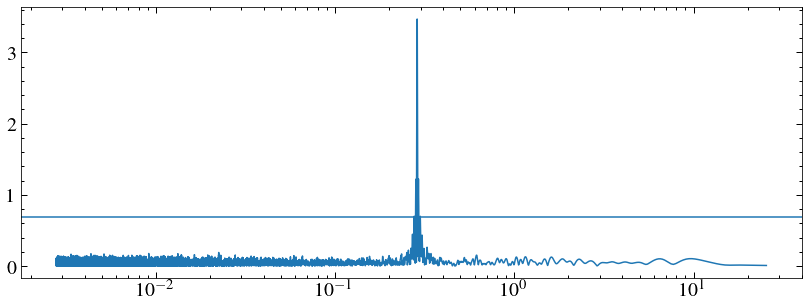

In [167]:
plt.plot(pg1.period, pg1.power)
plt.xscale('log')
plt.axhline(fa99)

So no short period :( make fancy plot. Find ephemeris properly?

2144.4623509128496
2157.206063856891
2157.2348962443575
2157.148218736583
Parameter('phase', value=1.2982676739155343) 0.4947485859182388
2459157.1482187365


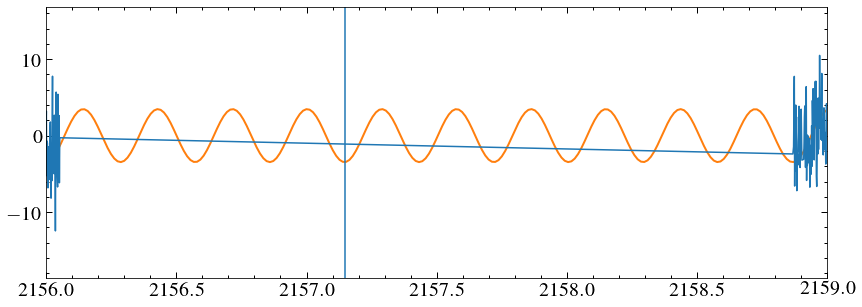

In [264]:
t0 = lc1.time[0] + (1/sin_fit.frequency)*(fold_fit.phase) #0.5 = inferior conjunction
print(t0)
tmid = np.mean(lc1.time)
print(tmid)
tmid2 = lc1.time[0] + (0.5 * (lc1.time[-1] - lc1.time[0]))
print(tmid2)
eph = t0 + np.mean(lc1.time)- lc1.time[0]
print(eph)

plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
plt.xlim(2156, 2159)
plt.axvline(eph)
#plt.axvline(tmid)
print(sin_fit.phase, sin_fit_e[2])
plt.plot(lc1.time, lc1.flux)

print(eph+2457000)

<ErrorbarContainer object of 3 artists>

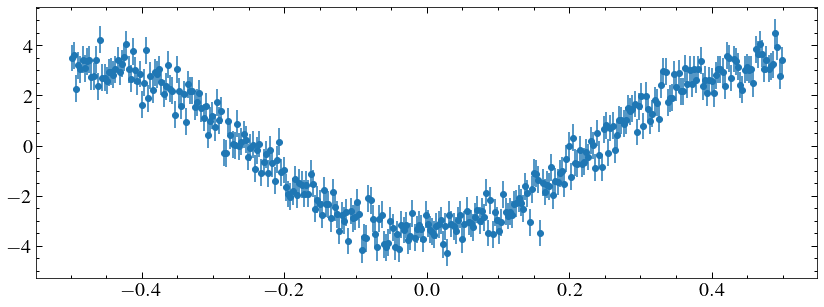

In [267]:
lcf = lc1.fold(1/sin_fit.frequency.value, t0=eph).bin(50)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')


In [272]:
#fits.getheader(lcpath, 1)

Final results  
Period = 6.88180 +/- 0.00045 h  
Amplitude = 3.464 +/- 0.039 %  
Ephemeris = 2459157.14821 0.00051   
Nice plot:

0.048887945624293515 %
0.026038696582869354 %


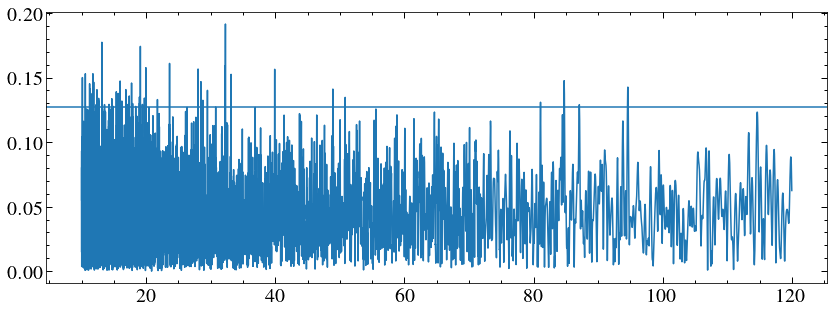

(array([7.210e+02, 1.902e+03, 2.882e+03, 3.571e+03, 3.910e+03, 3.874e+03,
        3.631e+03, 3.241e+03, 2.726e+03, 2.268e+03, 1.591e+03, 1.159e+03,
        7.610e+02, 4.740e+02, 3.280e+02, 2.000e+02, 1.420e+02, 7.000e+01,
        4.600e+01, 3.600e+01, 1.700e+01, 5.000e+00, 6.000e+00, 3.000e+00,
        3.000e+00]),
 array([4.97757377e-05, 7.70512638e-03, 1.53604770e-02, 2.30158277e-02,
        3.06711783e-02, 3.83265290e-02, 4.59818796e-02, 5.36372302e-02,
        6.12925809e-02, 6.89479315e-02, 7.66032822e-02, 8.42586328e-02,
        9.19139835e-02, 9.95693341e-02, 1.07224685e-01, 1.14880035e-01,
        1.22535386e-01, 1.30190737e-01, 1.37846087e-01, 1.45501438e-01,
        1.53156789e-01, 1.60812139e-01, 1.68467490e-01, 1.76122841e-01,
        1.83778191e-01, 1.91433542e-01]),
 <BarContainer object of 25 artists>)

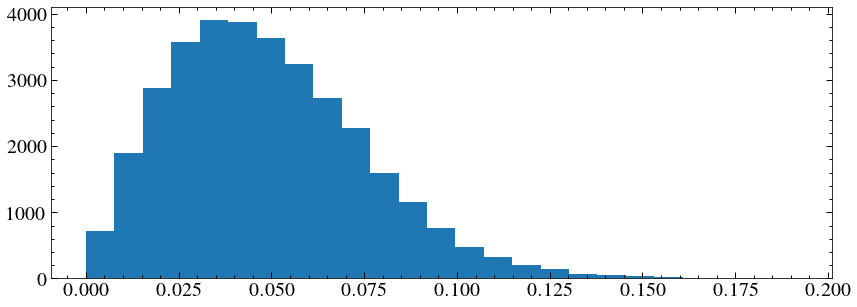

In [306]:
#rule out short periods.

pg1m = pg1.period.to(u.min)
pg1h = pg1.period.to(u.h)
mask = (pg1m > 10*u.min) & (pg1m < 120*u.min)
plt.plot(pg1m[mask], pg1.power[mask])
mean, std = np.mean(pg1.power[mask]).value, np.std(pg1.power[mask]).value
print(np.mean(pg1.power[mask]))
print(np.std(pg1.power[mask]))
plt.axhline(mean+3*std)
plt.show()
plt.hist(pg1.power[mask].value, bins=25)

In [393]:
b = 5
oc = lc1.bin(b).flux-sin_fit(lc1.bin(b).time)
print(np.mean(oc))
print(np.std(oc))

0.027277139175939626
1.594530937109243


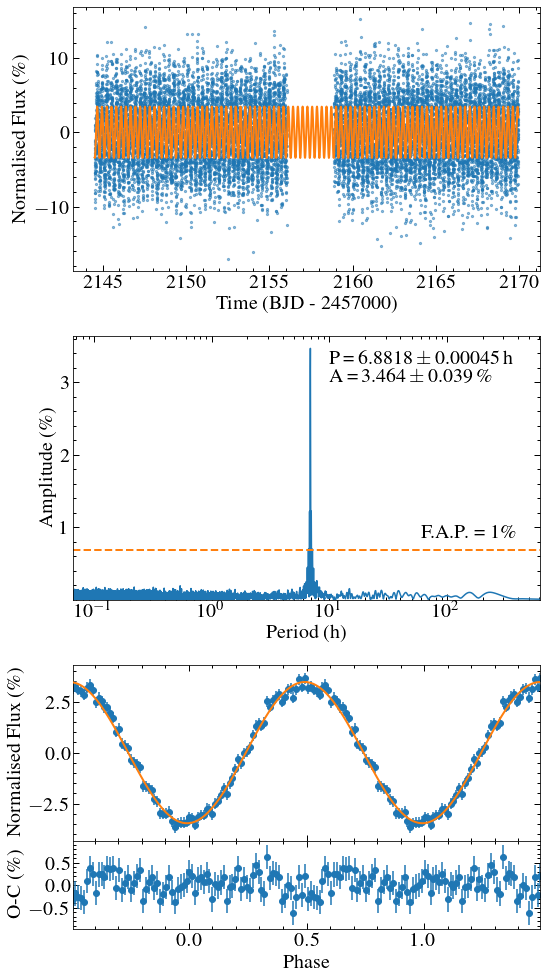

In [422]:
# fig,  (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 15))
plt.figure(figsize=(8, 14))
gs = GridSpec(3, 1, figure=fig)
plt.subplot(gs[1, :])
plt.plot(pg1h, pg1.power)
plt.xscale('log')
plt.axhline(fa99, c='C1', ls='--', lw=2)

plt.xlim(pg1h.value[-1], pg1h[0].value)
plt.ylim(0.0001)
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#axins = inset_axes(ax, width='40%', height='30%', loc=2)
#axins.plot(pg1m[mask], pg1.power[mask])
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.88180,0.00045, 3.464,  0.039), (10, 3.), xycoords='data')
plt.annotate('F.A.P. = 1\%', (0.95, fa99+0.1), xycoords=('axes fraction', 'data'), ha='right', va='bottom')

plt.subplot(gs[0, :])


plt.scatter(lc1.time, lc1.flux, s=5, rasterized=True, alpha=0.5) 
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 




plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)

gs1 = gs[2].subgridspec(3, 1, hspace=0)
plt.subplot(gs1[:2, :])
lcf = lc1.fold(1/sin_fit.frequency.value, t0=eph).bin(200)

lcf_mod =  models.Sine1D(amplitude=fold_fit.amplitude, frequency= 1, phase=0, fixed={'amplitude': True, 'frequency':True})
lcf_fit = fitter(lcf_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
#two cycles
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time, lcf_fit(fold_time), c='C1', lw=2, zorder=10)
plt.errorbar(lcf.time+1, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time+1, lcf_fit(fold_time), c='C1', lw=2, zorder=10)

plt.ylabel('Normalised Flux (\%)', size=20)
plt.xticks(visible=False)

xlims = [-0.49, 1.49] #storing here to update both plots at once
plt.xlim(xlims[0], xlims[1])

plt.subplot(gs1[2:, :])
mod = lcf_fit(lcf.time)
plt.errorbar(lcf.time, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.errorbar(lcf.time+1, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.xlim(xlims[0], xlims[1])
plt.ylabel('O-C (\%)', size=20)

plt.xlabel('Phase', size=20)
plt.tight_layout()
#plt.subplots_adjust(hspace=0.18)
# ax.subplots_adjust(hspace=0.7)
#ax1.set_top=0.99
#ax.set_bottom=0.01
plt.savefig('plots/cc_cet_tess_30s.pdf', dpi=150)

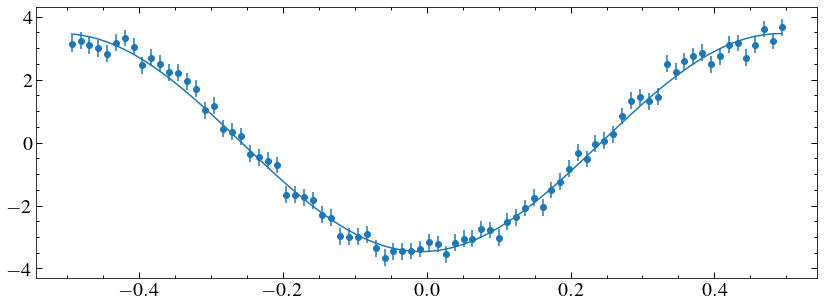

In [395]:
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(lcf.time, mod)

In [398]:
np.std(lcf.flux-mod)

0.23594227914789379